In [0]:
# Install the necessary libraries
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()

In [0]:

# Define Data Transforms
data_transforms={
     'train':transforms.Compose([
          transforms.RandomResizedCrop(224),
          transforms.RandomHorizontalFlip(),
          transforms.ToTensor(),
          transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
     ]),
     'val':transforms.Compose([
          transforms.Resize(256),
          transforms.CenterCrop(224),
          transforms.ToTensor(),
          transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
                               
     ]),
}


In [0]:
# unzip the dataset
!unzip hymenoptera_data.zip

Archive:  hymenoptera_data.zip
   creating: hymenoptera_data/
   creating: hymenoptera_data/train/
   creating: hymenoptera_data/train/ants/
  inflating: hymenoptera_data/train/ants/0013035.jpg  
  inflating: hymenoptera_data/train/ants/1030023514_aad5c608f9.jpg  
  inflating: hymenoptera_data/train/ants/1095476100_3906d8afde.jpg  
  inflating: hymenoptera_data/train/ants/1099452230_d1949d3250.jpg  
  inflating: hymenoptera_data/train/ants/116570827_e9c126745d.jpg  
  inflating: hymenoptera_data/train/ants/1225872729_6f0856588f.jpg  
  inflating: hymenoptera_data/train/ants/1262877379_64fcada201.jpg  
  inflating: hymenoptera_data/train/ants/1269756697_0bce92cdab.jpg  
  inflating: hymenoptera_data/train/ants/1286984635_5119e80de1.jpg  
  inflating: hymenoptera_data/train/ants/132478121_2a430adea2.jpg  
  inflating: hymenoptera_data/train/ants/1360291657_dc248c5eea.jpg  
  inflating: hymenoptera_data/train/ants/1368913450_e146e2fb6d.jpg  
  inflating: hymenoptera_data/train/ants/147318

In [0]:
# Source Data Directory
data_dir='hymenoptera_data'

# Load from directory to datasets
image_datasets={x:datasets.ImageFolder(os.path.join(data_dir,x), data_transforms[x])
             for x in ['train','val']}



# Load the datasets as DataLoaders
dataloaders={x:torch.utils.data.DataLoader(image_datasets[x],batch_size=4,
                                           shuffle=True,num_workers=4)
             for x in ['train','val']}



# Dataset size
dataset_sizes={x:len(image_datasets[x]) for x in ['train','val']}

# Labels definition
class_names=image_datasets['train'].classes

In [0]:
# GPU or CPU
device=torch.device("cuda:0"if torch.cuda.is_available()else "cpu")

In [0]:
# Image visualzier utility function
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

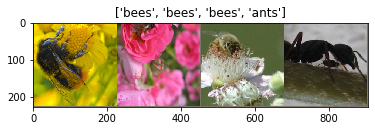

In [0]:
# Get a batch of training data
inputs,classes=next(iter(dataloaders['train']))

# Make a grid from batch
out=torchvision.utils.make_grid(inputs)
imshow(out,title=[class_names[x] for x in classes])



In [0]:
# Load the pretrained model
model_ft=models.resnet18(pretrained=True)
num_ftrs=model_ft.fc.in_features
model_ft.fc=nn.Linear(num_ftrs,len(class_names))
model_ft=model_ft.to(device)
criterion=nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft=optim.SGD(model_ft.parameters(),lr=0.001,momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler=lr_scheduler.StepLR(optimizer_ft,step_size=7,gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 330MB/s]


In [0]:
# Training Script
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [0]:
# Train the model
model_ft=train_model(model_ft,criterion,optimizer_ft,exp_lr_scheduler,num_epochs=25)



Epoch 0/24
----------
train Loss: 0.6391 Acc: 0.6803
val Loss: 0.2929 Acc: 0.9020

Epoch 1/24
----------
train Loss: 0.4085 Acc: 0.8197
val Loss: 0.2771 Acc: 0.9020

Epoch 2/24
----------
train Loss: 0.5346 Acc: 0.7623
val Loss: 0.2682 Acc: 0.8889

Epoch 3/24
----------
train Loss: 0.5810 Acc: 0.7828
val Loss: 0.3461 Acc: 0.8889

Epoch 4/24
----------
train Loss: 0.5197 Acc: 0.7910
val Loss: 0.3558 Acc: 0.8693

Epoch 5/24
----------
train Loss: 0.6583 Acc: 0.7541
val Loss: 0.3134 Acc: 0.8824

Epoch 6/24
----------
train Loss: 0.4946 Acc: 0.7951
val Loss: 0.2861 Acc: 0.9281

Epoch 7/24
----------
train Loss: 0.2865 Acc: 0.8730
val Loss: 0.2437 Acc: 0.9216

Epoch 8/24
----------
train Loss: 0.2020 Acc: 0.9303
val Loss: 0.2414 Acc: 0.9150

Epoch 9/24
----------
train Loss: 0.3839 Acc: 0.8566
val Loss: 0.2290 Acc: 0.9412

Epoch 10/24
----------
train Loss: 0.3377 Acc: 0.8484
val Loss: 0.2544 Acc: 0.8889

Epoch 11/24
----------
train Loss: 0.3175 Acc: 0.8689
val Loss: 0.2323 Acc: 0.9216

Ep

In [0]:
# Evaluation Script
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

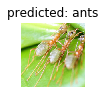

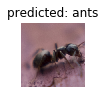

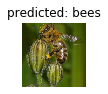

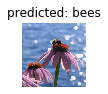

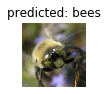

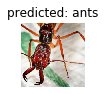

In [0]:
# Run Visualizer
visualize_model(model_ft)

In [0]:
# Save the model 
torch.save(model_ft,"best_model.pth")

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type ResNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Conv2d. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type BatchNorm2d. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type ReLU. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist

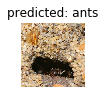

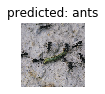

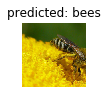

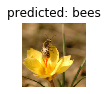

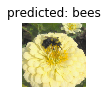

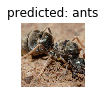

In [0]:
# To check model works fine ,load it
test_model=torch.load("best_model.pth")
test_model.eval()
visualize_model(test_model)


